In [1]:
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
def run_query(qry):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(qry, conn)

def run_command(com):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(com)
        
def show_tables():
        qry = 'SELECT name, type FROM sqlite_master WHERE type IN ("table","view")'
        return run_query(qry)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [4]:
usatsold = '''
WITH usa_inv AS (
SELECT * FROM customer
INNER JOIN invoice ON customer.customer_id = invoice.customer_id
INNER JOIN invoice_line il ON invoice.invoice_id = il.invoice_id
WHERE customer.country = 'USA')


SELECT
gr.name genre,
SUM(usa_inv.quantity) tracks_sold,
CAST(SUM(usa_inv.quantity) AS FLOAT) / CAST((SELECT SUM(quantity) FROM usa_inv) AS FLOAT) percentage
FROM genre gr
INNER JOIN track ON gr.genre_id = track.genre_id
INNER JOIN usa_inv ON track.track_id = usa_inv.track_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10
'''
run_query(usatsold)

,genre,tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [5]:
tr_sold_usa = run_query(usatsold)
tr_sold_usa.set_index('genre',drop=True,inplace=True)
tr_sold_usa

,tracks_sold,percentage
genre,,
Rock,561,0.533777
Alternative & Punk,130,0.123692
Metal,124,0.117983
R&B/Soul,53,0.050428
Blues,36,0.034253
Alternative,35,0.033302
Latin,22,0.020932
Pop,22,0.020932
Hip Hop/Rap,20,0.019029


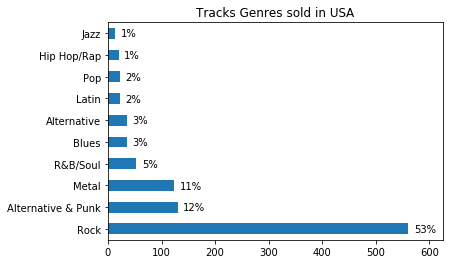

In [6]:
tr_sold_usa['tracks_sold'].plot( xlim=(0,625), kind='barh', title='Tracks Genres sold in USA')
plt.ylabel('')

for i, genre in enumerate(list(tr_sold_usa.index)):
    qty = tr_sold_usa.loc[genre, 'tracks_sold']
    perc = (tr_sold_usa.loc[genre, 'percentage'] * 100).astype(int).astype(str) + '%'
    plt.annotate(perc, (qty+10, i-0.15))

Among the 4 genres 'Punk' has the most tracks sold in USA, followed by 'Blues', 'Pop' and lastly 'Hip-Hop'.

Using these information as sole decision making consideration, then the 3 Artist & Genre chosen is:

'Red Tone - Punk' 
'Slim Jim Bites - Blues'
'Meteor and the Girls - Pop'

In [7]:
agentsales = '''
SELECT
e.first_name || ' ' || e.last_name agent_name,
e.title,
e.hire_date,
SUM(i.total) sales
FROM employee e
LEFT JOIN customer c ON e.employee_id = c.support_rep_id
LEFT JOIN invoice i ON c.customer_id = i.customer_id
WHERE e.title = 'Sales Support Agent'
GROUP BY agent_name
ORDER BY sales DESC
'''

pd_agentsales = run_query(agentsales)
pd_agentsales.set_index('agent_name', inplace=True, drop=True)
pd_agentsales

,title,hire_date,sales
agent_name,,,
Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,1731.51
Margaret Park,Sales Support Agent,2017-05-03 00:00:00,1584.00
Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,1393.92


Text(0, 0.5, '')

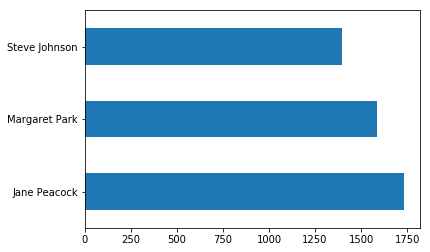

In [8]:
pd_agentsales['sales'].plot.barh()
plt.ylabel('')

In total, Jane Peacock sells the most followed by Margaret Park and Steve Johnson.
But considering when they were hired, Jane was hired almost 6 months before Steve, and Margaret 5 months before Steve, it is understandable that Jane has highest sales followed by Margaret then Steve.

In [9]:
a_countries = '''
WITH
c2 AS(
SELECT country, COUNT(distinct customer_id),
CASE
    WHEN COUNT(distinct customer_id) = 1 THEN 'Other'
    ELSE customer.country
END AS country2
FROM customer
GROUP BY 1)

SELECT country, total_customers, total_sales, sales_per_cust, sales_per_order
FROM (
    SELECT
    c2.country2 country,
    COUNT(distinct c.customer_id) total_customers,
    SUM(i.total) total_sales,
    SUM(i.total)/COUNT(distinct c.customer_id) sales_per_cust,
    SUM(i.total)/COUNT(distinct i.invoice_id) sales_per_order,
    CASE
        WHEN c2.country2 = 'Other' THEN 1
        ELSE 0
    END AS sort
    FROM customer c LEFT JOIN c2 ON c.country = c2.country
    INNER JOIN invoice i ON c.customer_id = i.customer_id
    GROUP BY 1
    ORDER BY 3 DESC)
ORDER BY sort
'''
run_query(a_countries)

,country,total_customers,total_sales,sales_per_cust,sales_per_order
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.448571


In [10]:
table = run_query(a_countries)
table.set_index('country', drop=True, inplace=True)

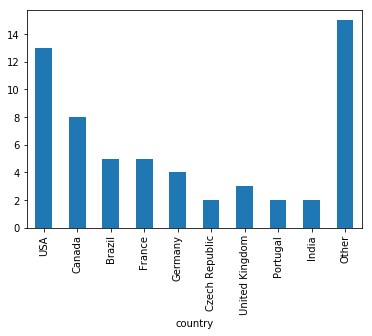

In [11]:
table['total_customers'].plot.bar()

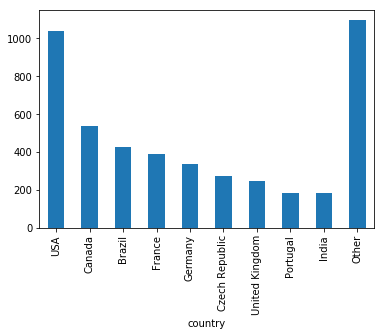

In [12]:
table['total_sales'].plot.bar()

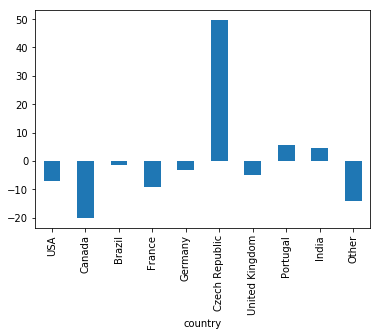

In [13]:
(table['sales_per_cust']-table['sales_per_cust'].mean()).plot.bar()

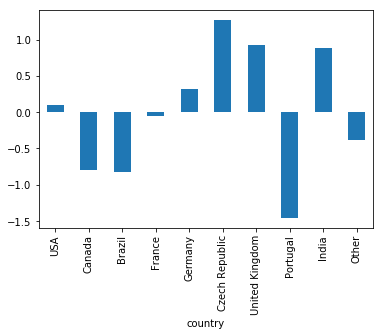

In [14]:
(table['sales_per_order']-table['sales_per_order'].mean()).plot.bar()

There are good potential of growth for Czech Republic, United Kingdom, and India. 3 of these countries have good sales_per_order numbers.

In [15]:
run_query('''
WITH album_tr AS (
SELECT
tr.album_id,
COUNT(distinct tr.track_id) album_tr_num
FROM track tr
GROUP BY 1)

SELECT
CASE
    WHEN COUNT(distinct il.track_id) = album_tr_num THEN 'yes'
    ELSE 'no'
END as album_purchase,
il.invoice_id,
COUNT(il.track_id) inv_tr_num,
album_tr_num
FROM invoice_line il
INNER JOIN track tr ON il.track_id = tr.track_id
INNER JOIN album_tr ON album_tr.album_id = tr.album_id
GROUP BY il.invoice_id
ORDER BY 2
''')

,album_purchase,invoice_id,inv_tr_num,album_tr_num
0,yes,1,16,16
1,no,2,10,11
2,no,3,2,17
3,no,4,8,9
4,yes,5,17,17
5,no,6,2,15
6,no,7,11,13
7,no,8,10,8
8,no,9,9,11
9,no,10,2,14


In [16]:
run_query('''
WITH album_tr AS (
SELECT
tr.album_id,
COUNT(distinct tr.track_id) album_tr_num
FROM track tr
GROUP BY 1),

combine AS (
SELECT
CASE
    WHEN COUNT(distinct il.track_id) = album_tr_num THEN 'yes'
    ELSE 'no'
END as album_purchase,
il.invoice_id
FROM invoice_line il
INNER JOIN track tr ON il.track_id = tr.track_id
INNER JOIN album_tr ON album_tr.album_id = tr.album_id
GROUP BY il.invoice_id)

SELECT
c.album_purchase,
COUNT(c.invoice_id) invoice_quantity,
CAST(COUNT(c.invoice_id) AS FLOAT) / CAST((SELECT COUNT(distinct invoice_id) FROM invoice_line) AS FLOAT) percent
FROM combine c
GROUP BY 1
''')

,album_purchase,invoice_quantity,percent
0,no,483,0.786645
1,yes,131,0.213355


19.7% customers did not purchase an album. There is a risk of losing this significant amount of customers if Chinook store decides to discontinue buying full albums. Therefore, it is not an advisable decision.